In [3]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import latexify as lt
import os
#from thinkdsp import read_json
import scipy
import speechpy
#LOSO Validation
loo = LeaveOneOut()
import tsfel
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import pickle

import pandas as pd
import numpy as np
from math import sqrt 
import matplotlib
import matplotlib.pyplot as plt

In [7]:
#load time series feature
with open('N95_Audio_Features.pickle', 'rb') as handle:
    all_features_features = pickle.load(handle)
    

    
def get_features(filepath, lungParam):
    
    
    
    feature_matrix_r = all_features_features[filepath.split('/')[-1]]
    
    
    
    return feature_matrix_r


def load_data(lungParam, sex, LH, file):
    '''
    feature: it is either 'FEV1', 'FVC' or 'PEF'
    '''
    data = pd.read_csv(file)
    
    if sex == 'M' or sex == 'F':
        data = data[data['Sex'] == sex]
    if LH == 'Y' or LH == 'N':
        data = data[data['LH'] == LH]
    
    
    #get the ground truth
    y=  np.array([i for i in data['g'+lungParam]])
    
    #prepare to store a lot of features in X
    X=[]
    count = 0
    for file in data['Filename']:
        features = get_features("SpiroMask-July2021/SmartMaskData/FVC/N95/"+file, lungParam)
        #print("Size of features = ",features.shape)
        X.append(features)
        count += 1
    X =  np.array(X)
    
    
    #add the estiamted lung param as a feature
    estiamtedValues = np.atleast_2d(data['r'+lungParam].to_numpy()).T
    X = np.hstack((X, estiamtedValues))
    # Return arrays to plug into sklearn's cross-validation algorithms
    return X, np.array(y)

## Forward Sequential Method

In [4]:
X_Cloth_PEF, Y_Cloth_PEF = load_data('PEF', 'A', 'A', "data_FVC_Cloth.csv")
X_Cloth_FEV1, Y_Cloth_FEV1 = load_data('FEV1', 'A', 'A', "data_FVC_Cloth.csv")
X_Cloth_FVC, Y_Cloth_FVC = load_data('FVC', 'A', 'A', "data_FVC_Cloth.csv")

In [8]:
X_N95_PEF, Y_N95_PEF = load_data('PEF', 'A', 'A', "data_FVC_N95.csv")
X_N95_FEV1, Y_N95_FEV1 = load_data('FEV1', 'A', 'A', "data_FVC_N95.csv")
X_N95_FVC, Y_N95_FVC = load_data('FVC', 'A', 'A', "data_FVC_N95.csv")

In [ ]:
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=100,  max_features='auto', max_depth=None)



listOfFeatures = []
listOfPE = []
lowestPE_PEF = 1.00
saturated = False

while len(listOfFeatures)<5 and saturated == False:
    X, Y = load_data('PEF', 'A', 'A', "data_FVC_Cloth.csv")
    loo.get_n_splits(X)
    lowestIndex_PEF = -1
    
    #CHANGE CATEGORY OF FEATURES HERE AND THEN SEE THE RESULT BELOW
    for i in range(390,780):
        if i not in listOfFeatures:
            listOfFeatures.append(i)
            X1 = X[:,listOfFeatures]

            pe = []
            #feature selection in forward sequential manner
            for train_index, test_index in loo.split(X1):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X1[train_index], X1[test_index]
                y_train, y_test = Y[train_index], Y[test_index]

                #for RF and SVR
                reg = regressor.fit(X_train, y_train)

                pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
                #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
                #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
            if np.mean(pe) <= lowestPE_PEF:
                lowestPE_PEF = np.mean(pe)
                lowestIndex_PEF = i
            #print(listOfFeatures)
            listOfFeatures.pop()
        else:
            print("Index = {} already added".format(i))
            
            
    if lowestPE_PEF in listOfPE:
        saturated = True;
    listOfFeatures.append(lowestIndex_PEF)
    listOfPE.append(lowestPE_PEF)
    #print("Lowest PE Recorded = ",lowestPE_PEF)
print("Features Saturated: Best Features are in index = {}".format(listOfFeatures))
print(listOfPE)

Features Saturated: Best Features are in index = [995, 285, 502, -1] <br>
[0.22355492232366314, 0.17510270392905958, 0.1710750352642656, 0.1710750352642656]

In [54]:
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=5,  max_features='auto', max_depth=None)



listOfFeatures = []
listOfPE = []
lowestPE_PEF = 1.00
saturated = False

while len(listOfFeatures)<5 and saturated == False:
    X, Y = load_data('FEV1', 'A', 'A', "data_FVC_Cloth.csv")
    loo.get_n_splits(X)
    lowestIndex_PEF = -1
    
    for i in range(0,X.shape[1]):
        if i not in listOfFeatures:
            listOfFeatures.append(i)
            X1 = X[:,listOfFeatures]

            pe = []
            #feature selection in forward sequential manner
            for train_index, test_index in loo.split(X1):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X1[train_index], X1[test_index]
                y_train, y_test = Y[train_index], Y[test_index]

                #for RF and SVR
                reg = regressor.fit(X_train, y_train)

                pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
                #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
                #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
            if np.mean(pe) < lowestPE_PEF:
                lowestPE_PEF = np.mean(pe)
                lowestIndex_PEF = i
            #print(listOfFeatures)
            listOfFeatures.pop()
        if lowestPE_PEF in listOfPE:
            saturated = True;
    listOfFeatures.append(lowestIndex_PEF)
    listOfPE.append(lowestPE_PEF)
    #print("Lowest PE Recorded = ",lowestPE_PEF)
print("Features Saturated: Best Features are in index = {}".format(listOfFeatures))
print(listOfPE)

Features Saturated: Best Features are in index = [809, 748]
[0.16993066725425895, 0.09920300181054797]


In [55]:
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=5,  max_features='auto', max_depth=None)



listOfFeatures = []
listOfPE = []
lowestPE_PEF = 1.00
saturated = False

while len(listOfFeatures)<5 and saturated == False:
    X, Y = load_data('FVC', 'A', 'A', "data_FVC_Cloth.csv")
    loo.get_n_splits(X)
    lowestIndex_PEF = -1
    
    for i in range(0,X.shape[1]):
        if i not in listOfFeatures:
            listOfFeatures.append(i)
            X1 = X[:,listOfFeatures]

            pe = []
            #feature selection in forward sequential manner
            for train_index, test_index in loo.split(X1):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X1[train_index], X1[test_index]
                y_train, y_test = Y[train_index], Y[test_index]

                #for RF and SVR
                reg = regressor.fit(X_train, y_train)

                pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
                #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
                #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
            if np.mean(pe) < lowestPE_PEF:
                lowestPE_PEF = np.mean(pe)
                lowestIndex_PEF = i
            #print(listOfFeatures)
            listOfFeatures.pop()
        if lowestPE_PEF in listOfPE:
            saturated = True;
    listOfFeatures.append(lowestIndex_PEF)
    listOfPE.append(lowestPE_PEF)
    #print("Lowest PE Recorded = ",lowestPE_PEF)
print("Features Saturated: Best Features are in index = {}".format(listOfFeatures))
print(listOfPE)

Features Saturated: Best Features are in index = [809, 874]
[0.15459750500869976, 0.12679763235165553]


## Using The Best Hyperparameters For PEF/FEV1/FVC

In [13]:
#compare with base model
#ML inits
#regressor = RandomForestRegressor(n_estimators = 5000, random_state = 0, )
#regressor = SVR(kernel = 'rbf', C=0.1, gamma='auto')
#regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,max_depth = 50, alpha = 10, n_estimators = 50)
#regressor = Lasso(alpha = 0.01)
#regressor = Ridge(alpha=0.01)
#regressor = LinearRegression()
#regressor = BaggingRegressor(base_estimator=RandomForestRegressor(), n_estimators=10000, n_jobs=-1)
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=1000,  max_features='auto', max_depth=None)

#load_data(param, Sex, Lung issue?)
X, Y = load_data('PEF', 'A', 'A', "data_FVC_Cloth.csv")
loo.get_n_splits(X)


print("Getting the performence of model on PEF")
#base = RandomForestRegressor(criterion='mae', n_estimators = 10, random_state = 42)
#print("\n\n****Running Regression on PEF****")
 
pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    #reg = base.fit(X_train, y_train)
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    #trueValue.append(y_test)
    #predictedValue.append(reg.predict(X_test))
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))




#load_data(param, Sex, Lung issue?)
X, Y = load_data('FEV1', 'A', 'A', "data_FVC_Cloth.csv")
loo.get_n_splits(X)


print("Getting the performence of model on FEV1")
#base = RandomForestRegressor(criterion='mae', n_estimators = 10, random_state = 42)
#print("\n\n****Running Regression on PEF****")

pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    #reg = base.fit(X_train, y_train)
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    #trueValue.append(y_test)
    #predictedValue.append(reg.predict(X_test))
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))





#load_data(param, Sex, Lung issue?)
X, Y = load_data('FVC', 'A', 'A', "data_FVC_Cloth.csv")
loo.get_n_splits(X)


print("Getting the performence of model on FVC")
#base = RandomForestRegressor(criterion='mae', n_estimators = 10, random_state = 42)
#print("\n\n****Running Regression on PEF****")

pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    #reg = base.fit(X_train, y_train)
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    #trueValue.append(y_test)
    #predictedValue.append(reg.predict(X_test))
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))



Getting the performence of model on PEF
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [0]
Predicted=  6.856863999999954
True =  4.39
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [1]
Predicted=  8.066751999999795
True =  7.0
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [2]
Predicted=  4.485798999999744
True =  4.5
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [3]
Predicted=  4.265045999999745
True =  7.12
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [4]
Predicted=  7.74279599999959
True =  7.81
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [5]
Predicted=  6.331051999999452
True =  4.07
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [6]
Predicted=  7.275615999999761
True =  2.52
TRAIN: [ 0  1  2  3  4  5

Predicted=  3.4646379999996135
True =  3.6
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [10]
Predicted=  3.40073999999962
True =  3.76
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [11]
Predicted=  3.6850339999995856
True =  2.89
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [12]
Predicted=  3.385211999999741
True =  3.76
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24] TEST: [13]
Predicted=  3.3929520000000832
True =  3.31
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24] TEST: [14]
Predicted=  3.2401670000002842
True =  3.31
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24] TEST: [15]
Predicted=  2.9599630000002106
True =  0.93
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24] TEST: [16]
Predicted=  2.3042169999996998
True =  2.07
TRAIN: [

## Feature Importance

In [15]:
'''
0-389: Stat Features (390)
390-779: Stat Features From Envelope (390)
780-819: MFE Features (40)
820-859: Log Energy Features (40)
860-872: MFCC CMVN Features (13)
873-1129: Power Spectrum Features (257)
1130-1193: Melspectogram Features (64)
1194-1205: Chroma Features (12)
1206-1206: Spectral Roll off (1)
1207-1207: ZCR (1)
'''
for param in ['PEF']:
    X, Y = load_data(param, 'A', 'A', "data_FVC_Cloth.csv")

    loo.get_n_splits(X)
    feature_names = [f'feature {i}' for i in range(X.shape[1])]
    
    if param == 'PEF':
        avg_feat_importances_PEF = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    elif param == 'FEV1':
        avg_feat_importances_FEV1 = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    elif param == 'FVC':
        avg_feat_importances_FVC = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    
    regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_features='auto', max_depth=100)
    count=0;
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        #for RF and SVR
        reg = regressor.fit(X_train, y_train)
        importances = reg.feature_importances_
        feat_importances = pd.Series(importances, index=feature_names)
        
        if param == 'PEF':
            avg_feat_importances_PEF = avg_feat_importances_PEF.add(feat_importances)
           
        elif param == 'FEV1':
            avg_feat_importances_FEV1 = avg_feat_importances_FEV1.add(feat_importances)
            
        elif param == 'FVC':
            avg_feat_importances_FVC = avg_feat_importances_FVC.add(feat_importances)
            
        
        count+=1;
        #feat_importances.nlargest(10).plot(kind='barh', figsize=(5,10))
        #plt.show()

        
    if param == 'PEF':
        avg_feat_importances_PEF = avg_feat_importances_PEF.divide(other=count)
    elif param == 'FEV1':
        avg_feat_importances_FEV1 = avg_feat_importances_FEV1.divide(other=count)
    elif param == 'FVC':
        avg_feat_importances_FVC = avg_feat_importances_FVC.divide(other=count)

#feat_importances = pd.Series(importances, index=feature_names)


528 116383 441 220.0
583 128624 441 220.0
720 158659 441 220.0
752 165677 441 220.0
746 164371 441 220.0
791 174328 441 220.0
651 143641 441 220.0
579 127645 441 220.0
820 180693 441 220.0
737 162413 441 220.0
535 117934 441 220.0
382 84321 441 220.0
681 150085 441 220.0
501 110514 441 220.0
479 105699 441 220.0
428 94504 441 220.0
794 174981 441 220.0
789 173839 441 220.0
1027 226347 441 220.0
523 115330 441 220.0
523 115330 441 220.0
411 90756 441 220.0
541 119255 441 220.0
766 168778 441 220.0
651 143478 441 220.0


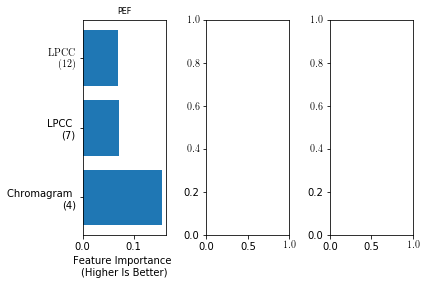

In [16]:
fig, ax = plt.subplots(1,3)
lt.latexify(columns=2, fig_height=3.0)

ax[0].bar(avg_feat_importances_PEF.nlargest(3).index, avg_feat_importances_PEF.nlargest(3).values)
ax[0].set_ylim([0,1])
ax[1].bar(avg_feat_importances_FEV1.nlargest(3).index, avg_feat_importances_FEV1.nlargest(3).values)
ax[1].set_ylim([0,1])
ax[2].bar(avg_feat_importances_FVC.nlargest(3).index, avg_feat_importances_FVC.nlargest(3).values)
ax[2].set_ylim([0,1])

ax[0].barh(['Chromagram \n(4)', 'LPCC \n(7)', 'LPCC \n(12)'], avg_feat_importances_PEF.nlargest(3).values)
ax[0].set_title('PEF')
ax[0].set_xlabel('Feature Importance \n(Higher Is Better)')

lt.format_axes(ax[0])
ax[1].barh(['Spectogram \n(12)', 'Power \nSpectogram \n(7)', 'Melspectogram \n(6)'], avg_feat_importances_FEV1.nlargest(3).values)
ax[1].set_title('FEV1')
ax[1].set_xlabel('Feature Importance \n(Higher Is Better)')
lt.format_axes(ax[1])
ax[2].barh(['MFCC (13) \nMean and \nVariance\n Normalised', 'Power\nSpectogram \n(7)', 'Histogram \n(6)'], avg_feat_importances_FEV1.nlargest(3).values)
ax[2].set_title('FVC')
ax[2].set_xlabel('Feature Importance \n(Higher Is Better)')
lt.format_axes(ax[2])

plt.tight_layout()
#plt.savefig("feature_importance.pdf", bbox_inches='tight')


## Feature Ablation

### Generate Final Plots For Paper

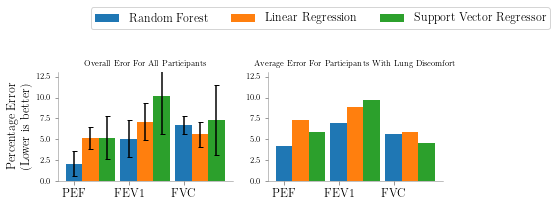

In [8]:
# plots to be manullly made using results from sheet
#N95 Mask
#get final numbers by running the ML pipeline above
rf_pe= [2.1,5.1,6.7]
lr_pe = [5.2,7.1,5.6]
svr_pe = [5.2,10.2,7.3]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [4.2,7,5.65]
lr_pe_u = [7.3,8.85,5.85]
svr_pe_u = [5.85,9.75,4.55]


figname = 'revised-overall-error-n95'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

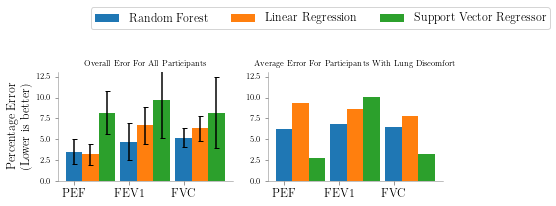

In [9]:
# plots to be manullly made using results from sheet
#Cloth Mask

#get final numbers by running the ML pipeline above
rf_pe= [3.5,4.7,5.2]
lr_pe = [3.2,6.7,6.3]
svr_pe = [8.2,9.7,8.2]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [6.2,6.8,6.5]
lr_pe_u = [9.3,8.6,7.8]
svr_pe_u = [2.8,10.1,3.21]


figname = 'revised-overall-error-cloth'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
#ax[0].annotate(' Result For Cloth Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

## Generate Bland-Altman Plots

In [4]:
# Original Author: Prof. Nipun Batra
# nipunbatra.github.io

SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
  """Set up matplotlib's RC params for LaTeX plotting.
  Call this before plotting a figure.
  Parameters
  ----------
  fig_width : float, optional, inches
  fig_height : float,  optional, inches
  columns : {1, 2}
  """

  # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

  # Width and max height in inches for IEEE journals taken from
  # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

  assert(columns in [1,2])

  if fig_width is None:
    fig_width = 3.39 if columns==1 else 6.9 # width in inches

  if fig_height is None:
    golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
    fig_height = fig_width*golden_mean # height in inches

  MAX_HEIGHT_INCHES = 8.0
  if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES

  params = {'backend': 'ps',
            'text.latex.preamble': ['\\usepackage{gensymb}'],
            'axes.labelsize': 8, # fontsize for x and y labels (was 10)
            'axes.titlesize': 8,
            'font.size': 8, # was 10
            'legend.fontsize': 8, # was 10
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'text.usetex': False,
            'figure.figsize': [fig_width,fig_height],
            'font.family': 'serif'
  }

  matplotlib.rcParams.update(params)


def format_axes(ax):
  for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

  for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(SPINE_COLOR)
    ax.spines[spine].set_linewidth(0.5)

  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  for axis in [ax.xaxis, ax.yaxis]:
    axis.set_tick_params(direction='out', color=SPINE_COLOR)

  return ax

def bland_altman(csv_file_paths:list, titles:list=['FVC', 'FEV$_1$', 'PEF'], labels:list=['Healthy', 'Not Healthy'], column_names:list = ['x', 'y'], log_transform:bool = False, save_fig:str = None):
  """
  Function to create a Bland-Altman plot 

  Args:
    csv_file_paths: list of str
      File paths of the csv files containing the data. Each csv file should
      contain 2 columns - one for each method.

    titles: list of str, default: ['FVC', 'FEV$_1$', 'PEF']
      Titles for the 3 subplots

    labels: list of str, default: ['Healthy', 'Not Healthy']
      labels for the 2 traces

    column_names: list of str, default: ['x', 'y']
      Names to be used for the columns in the csv files. The first column is x
      and second column is y by default.

    log_transform: bool, default: False
      Whether to use log transformation (base 2) of the measurements before the 
      analysis 

    save_fig: str, default: None
      path to save image in, does not save if None

  Returns:
    None
  """
  fig, ax = plt.subplots(nrows=1, ncols=3)

  for title, h in zip(titles, range(3)):
    for k, path in enumerate(csv_file_paths[h*2:h*2+2]):
      data = pd.read_csv(path, header=0, names=column_names)

      # use log transformation on data if log_transform is True
      if log_transform:
        data['x'] = np.log2(data['x'])
        data['y'] = np.log2(data['y'])

      averages = (data['x'] + data['y'])/2
      differences = data['x'] - data['y']

      # add the Bland-Altman plot to the figure
      ax[h].scatter(x=averages, y=differences, label=labels[k], 
                color='C'+str(k))
      
      # add mean and +/- 1.96*SD lines only for the first file
      if k == 0:
        average_difference = differences.mean()
        sd_difference = differences.std()
        
        # add mean of the differences to the figure
        ax[h].axhline(y=average_difference,
                  label='mean', color='k', alpha=0.8)
        
        # add mean + 1.96*SD of the differences to the figure
        ax[h].axhline(y=average_difference + 1.96*sd_difference,
                  linestyle='dashed',
                  label='+1.96SD', color='k', alpha=0.8)
        
        # add mean - 1.96*SD of the differences to the figure
        ax[h].axhline(y=average_difference - 1.96*sd_difference,
                  linestyle='dashed',
                  label='-1.96SD', color='k', alpha=0.8)
    
    # update titles, set legend
    ax[h].set_title(title)
    ax[h].set_xlabel('Average of the 2 methods')
    # update y-axis title only for first subplot
    if h == 0:
      ax[h].set_ylabel('Difference between the 2 methods')
    # add legend for middle subplot
    if h == 1:
      ax[h].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5)
    format_axes(ax[h])
    

  plt.subplots_adjust(wspace=0.3)
  if save_fig is None:
    plt.show()
  else:
    plt.savefig(save_fig, bbox_inches='tight')


Generate files by running the codes above

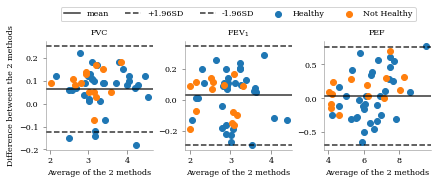

In [6]:

latexify(columns=2, fig_height=2)
# pass only one file name in the list if you only 
# want to plot one file in each figure
bland_altman(['result-FVC-N95-Healthy.csv', 'result-FVC-N95-Not-Healthy.csv', 
            'result-FEV1-N95-Healthy.csv', 'result-FEV1-N95-Not-Healthy.csv',
            'result-PEF-N95-Healthy.csv', 'result-PEF-N95-Not-Healthy.csv'], 
            log_transform=False, 
            save_fig=None) 

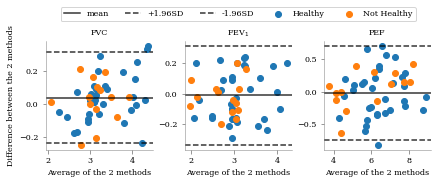

In [7]:

latexify(columns=2, fig_height=2)
# pass only one file name in the list if you only 
# want to plot one file in each figure
bland_altman(['result-FVC-Cloth-Healthy.csv', 'result-FVC-Cloth-Not-Healthy.csv', 
            'result-FEV1-Cloth-Healthy.csv', 'result-FEV1-Cloth-Not-Healthy.csv',
            'result-PEF-Cloth-Healthy.csv', 'result-PEF-Cloth-Not-Healthy.csv'], 
            log_transform=False, 
            save_fig=None) 